In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import warnings

warnings.filterwarnings("ignore")


In [ ]:

# Load the dataset
file_path = '/content/drive/MyDrive/archive/data set.csv'  # replace with actual path
data = pd.read_csv(file_path)

# Overview of the dataset
print("Data shape:", data.shape)
print("First few rows of the data:\n", data.head())

# Convert non-numeric columns (such as dates) to numeric where possible
data = data.apply(pd.to_numeric, errors='coerce')

# Drop columns with a high percentage of NaN values (e.g., more than 50%)
nan_threshold = 0.5
data = data.loc[:, data.isnull().mean() < nan_threshold]

# Drop rows with NaN values
data = data.dropna()
print("Data shape after cleaning:", data.shape)

# Check if the FLAG column exists
if 'FLAG' not in data.columns:
    print("Error: 'FLAG' column not found in the dataset.")
else:
    # Define features and target variable
    X = data.drop(columns=['FLAG'])  # Features
    y = data['FLAG']                 # Target variable






Data shape: (42372, 1036)
First few rows of the data:
    1/1/2014  1/2/2014  1/3/2014  1/4/2014  1/5/2014  1/6/2014  1/7/2014  \
0       0.0       0.0      0.01       0.0       0.0      0.00      0.00   
1       0.0       0.0      0.00       0.0       0.0      0.00      0.00   
2       0.0       0.0      0.00       0.0       0.0      4.98      9.87   
3       0.0       0.0      0.00       0.0       0.0      0.00      0.00   
4       0.0       0.0      0.00       0.0       0.0      0.00      0.00   

   1/8/2014  1/9/2014  1/10/2014  ...  10/24/2016  10/25/2016  10/26/2016  \
0      0.00      0.00       0.00  ...        0.02        0.06        0.58   
1      0.00      0.00       0.00  ...       17.13       14.32       16.37   
2     11.29     13.44      11.34  ...         NaN        1.43        2.22   
3      0.00      0.00       0.00  ...       20.98       18.47       15.50   
4      0.00      0.00       0.00  ...        0.61        1.33        0.55   

   10/27/2016  10/28/2016  10/2

In [ ]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

    # --- Anomaly Detection with Local Outlier Factor ---
print("\n--- Anomaly Detection using Local Outlier Factor ---")
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1, novelty=True)
lof.fit(X_train)

    # Predict on test set
y_pred_lof = lof.predict(X_test)
y_pred_lof = np.where(y_pred_lof == -1, 1, 0)  # Convert -1 to 1 (anomaly) and 1 to 0 (normal)

    # Evaluate Anomaly Detection
print("LOF Classification Report:\n", classification_report(y_test, y_pred_lof))
print("LOF Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lof))

    # --- Novelty Detection with Deep Learning ---
print("\n--- Novelty Detection using Autoencoder ---")
    # Prepare data for novelty detection (using normal data only for training)
X_train_normal = X_train[y_train == 0]

    # Build the autoencoder model
model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train_normal.shape[1],)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(64, activation='relu'),
        Dense(128, activation='relu'),
        Dense(X_train_normal.shape[1], activation='sigmoid')
    ])

model.compile(optimizer='adam', loss='mse')
model.summary()

    # Train the autoencoder
history = model.fit(X_train_normal, X_train_normal, epochs=200, batch_size=256, validation_split=0.2, verbose=1)

    # Set reconstruction error threshold for novelty detection
reconstructions = model.predict(X_train_normal)
train_loss = np.mean(np.square(reconstructions - X_train_normal), axis=1)
threshold = np.percentile(train_loss, 95)
print("Reconstruction error threshold:", threshold)



--- Anomaly Detection using Local Outlier Factor ---
LOF Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.90      0.93       298
           1       0.09      0.20      0.12        15

    accuracy                           0.87       313
   macro avg       0.52      0.55      0.53       313
weighted avg       0.92      0.87      0.89       313

LOF Confusion Matrix:
 [[268  30]
 [ 12   3]]

--- Novelty Detection using Autoencoder ---


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                     │ (None, 128)                 │         132,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1032)                │         133,128 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 286,120 (1.09 MB)

 Trainable params: 286,120 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.5555 - val_loss: 0.5445
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.5389 - val_loss: 0.4462
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.4388 - val_loss: 0.3383
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2732 - val_loss: 0.2839
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.3507 - val_loss: 0.2706
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2683 - val_loss: 0.2670
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2502 - val_loss: 0.2578
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2135 - val_loss: 0.2533
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.3109 - val_loss: 0.2484
Epoch 10/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.2463 - val_loss: 0.2400
Epoch 11/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.2858 - val_loss: 0.2309
Epoch 12/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1873 - val_lo

In [ ]:

    # Test the model on test data
reconstructions = model.predict(X_test)
test_loss = np.mean(np.square(reconstructions - X_test), axis=1)
y_pred_novelty = np.where(test_loss > threshold, 1, 0)

      # Evaluate Novelty Detection
print("Novelty Detection Classification Report:\n", classification_report(y_test, y_pred_novelty))
print("Novelty Detection Confusion Matrix:\n", confusion_matrix(y_test, y_pred_novelty))

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Novelty Detection Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95       298
           1       0.14      0.20      0.17        15

    accuracy                           0.90       313
   macro avg       0.55      0.57      0.56       313
weighted avg       0.92      0.90      0.91       313

Novelty Detection Confusion Matrix:
 [[280  18]
 [ 12   3]]


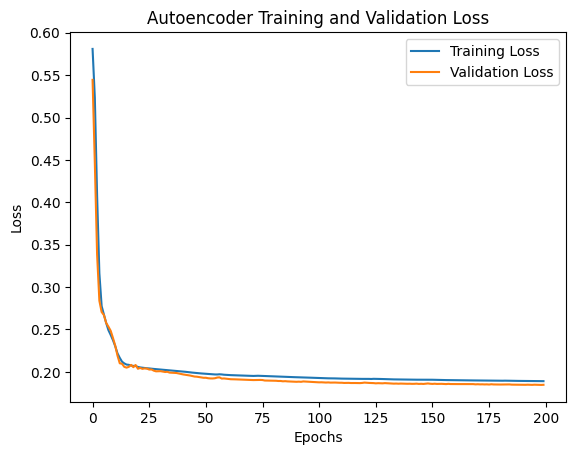

In [ ]:
 # Visualize training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Autoencoder Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()